In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

In [97]:
DATA_DIR = '../data/titanic'
data_files = reversed([os.path.join(DATA_DIR, filename) for filename in os.listdir(DATA_DIR)])
df_list = []
for filename in data_files:
    df_list.append(pd.read_csv(filename))
df = pd.concat(df_list, sort=False)
df = df.reset_index(drop=True)

number_of_train_dataset = df.Survived.notnull().sum()
number_of_test_dataset = df.Survived.isnull().sum() 
y_true = df.pop("Survived")[:number_of_train_dataset]

df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [3]:
df["Age"].fillna(
    df.groupby("Pclass")["Age"].transform("mean"), inplace=True)

### One-hot encoding

In [4]:
object_columns = ["PassengerId", "Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
numeric_columns = ["Age", "SibSp", "Parch", "Fare"]

In [5]:
for col_name in object_columns:
    df[col_name] = df[col_name].astype(object)

for col_name in numeric_columns:
    df[col_name] = df[col_name].astype(float)
df["Parch"] = df["Parch"].astype(int)
df["SibSp"] = df["SibSp"].astype(int)


In [6]:
def merge_and_get(ldf, rdf, on, how="inner", index=None):
    if index is True:
        return pd.merge(ldf,rdf, how=how, left_index=True, right_index=True)
    else:
        return pd.merge(ldf,rdf, how=how, on=on)

In [7]:
df.loc[61,"Embarked"]           = "S"
df.loc[829,"Embarked"]           = "S"

In [8]:
one_hot_df = merge_and_get(df, pd.get_dummies(df["Sex"], prefix="Sex"), on=None, index=True) #sex_modified
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(df["Pclass"], prefix="Pclass"), on=None, index=True) #sex_modified
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(df["Embarked"], prefix="Embarked"), on=None, index=True) #sex_modified


### Mean Encoding

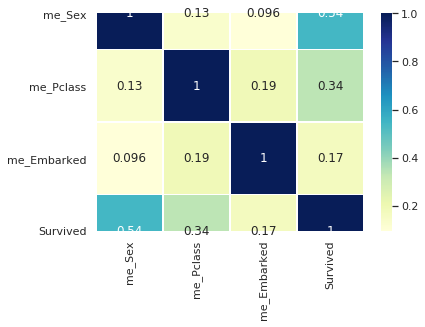

In [10]:
temp_columns = ["Sex", "Pclass", "Embarked"]

me_list = []
for col_name in temp_columns:
    temp_df = pd.merge(one_hot_df[col_name], y_true, left_index=True, right_index=True)
    temp_df["me_"+col_name] = temp_df[col_name].replace(temp_df.groupby(col_name)["Survived"].mean())
#     sns.countplot(x=col_name, hue="Survived", data=temp_df)    
#     plt.show()
#     sns.countplot(x="me_"+col_name, hue="Survived", data=temp_df)
#     plt.show()
    
    me_list.append(temp_df.drop("Survived", axis=1))
temp_df =  pd.merge(
    pd.concat(me_list,axis=1)[["me_" + col_name for col_name in temp_columns ]],
    y_true, left_index=True, right_index=True)
corr =  temp_df.corr()
sns.set()
ax = sns.heatmap(corr, annot=True,  linewidths=.5, cmap="YlGnBu")

### Categorical Combination

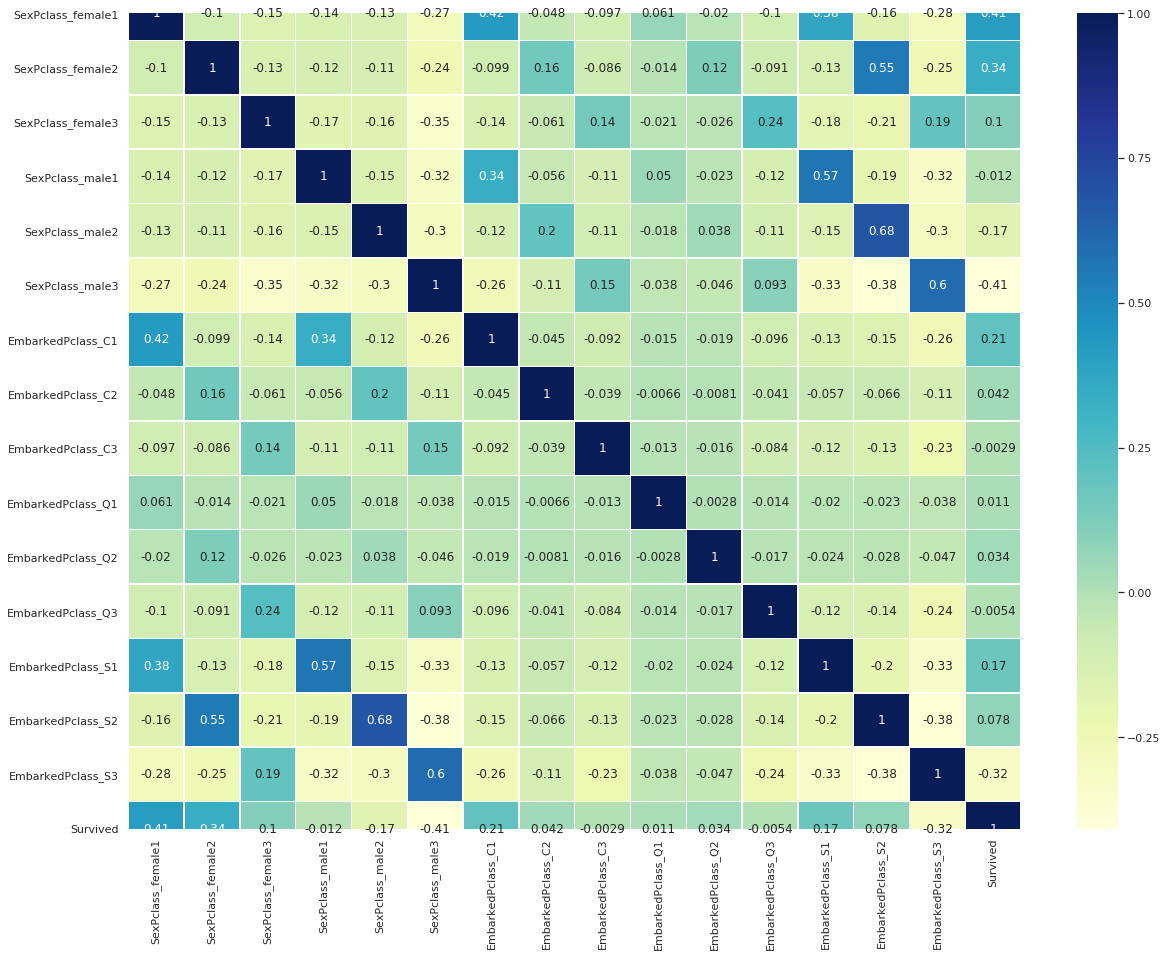

In [11]:
temp_columns = ["Sex", "Pclass", "Embarked"]
one_hot_df["Sex-Pclass"] = df["Sex"].map(str)+df["Pclass"].map(str)
one_hot_df["Embarked-Pclass"] = df["Embarked"].map(str)+df["Pclass"].map(str)

one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(one_hot_df["Sex-Pclass"], prefix="SexPclass"), on=None, index=True) #sex_modified
one_hot_df = merge_and_get(one_hot_df, pd.get_dummies(one_hot_df["Embarked-Pclass"], prefix="EmbarkedPclass"), on=None, index=True) #sex_modified
one_hot_df

crosscheck_columns = [col_name for col_name in one_hot_df.columns.tolist()
                     if col_name.split("_")[0] in ["SexPclass", "EmbarkedPclass"] and  "_"  in col_name ] 

temp_df = pd.merge(one_hot_df[crosscheck_columns], y_true, left_index=True, right_index=True)

corr =  temp_df.corr()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr, annot=True,  linewidths=.5, cmap="YlGnBu")

In [12]:
corr

,SexPclass_female1,SexPclass_female2,SexPclass_female3,SexPclass_male1,SexPclass_male2,SexPclass_male3,EmbarkedPclass_C1,EmbarkedPclass_C2,EmbarkedPclass_C3,EmbarkedPclass_Q1,EmbarkedPclass_Q2,EmbarkedPclass_Q3,EmbarkedPclass_S1,EmbarkedPclass_S2,EmbarkedPclass_S3,Survived
SexPclass_female1,1.000000,-0.104873,-0.150784,-0.136789,-0.127546,-0.274284,0.423255,-0.047896,-0.097136,0.060911,-0.019961,-0.101826,0.377834,-0.163113,-0.278183,0.412581
SexPclass_female2,-0.104873,1.000000,-0.134075,-0.121631,-0.113412,-0.243890,-0.099168,0.163005,-0.086372,-0.014484,0.120976,-0.090542,-0.125645,0.549630,-0.247357,0.337329
SexPclass_female3,-0.150784,-0.134075,1.000000,-0.174879,-0.163062,-0.350660,-0.142581,-0.061234,0.143588,-0.020825,-0.025520,0.239003,-0.180650,-0.208533,0.192935,0.104873
SexPclass_male1,-0.136789,-0.121631,-0.174879,1.000000,-0.147927,-0.318113,0.337427,-0.055550,-0.112658,0.050095,-0.023151,-0.118098,0.569092,-0.189178,-0.322636,-0.012274
SexPclass_male2,-0.127546,-0.113412,-0.163062,-0.147927,1.000000,-0.296617,-0.120607,0.199569,-0.105045,-0.017616,0.037777,-0.110117,-0.152809,0.684336,-0.300834,-0.172920
SexPclass_male3,-0.274284,-0.243890,-0.350660,-0.318113,-0.296617,1.000000,-0.259363,-0.111387,0.152008,-0.037882,-0.046422,0.092555,-0.328611,-0.379332,0.600105,-0.407925
EmbarkedPclass_C1,0.423255,-0.099168,-0.142581,0.337427,-0.120607,-0.259363,1.000000,-0.045291,-0.091852,-0.015403,-0.018875,-0.096287,-0.133616,-0.154240,-0.263050,0.207192
EmbarkedPclass_C2,-0.047896,0.163005,-0.061234,-0.055550,0.199569,-0.111387,-0.045291,1.000000,-0.039447,-0.006615,-0.008106,-0.041352,-0.057383,-0.066240,-0.112970,0.041747
EmbarkedPclass_C3,-0.097136,-0.086372,0.143588,-0.112658,-0.105045,0.152008,-0.091852,-0.039447,1.000000,-0.013416,-0.016440,-0.083863,-0.116376,-0.134338,-0.229109,-0.002937
EmbarkedPclass_Q1,0.060911,-0.014484,-0.020825,0.050095,-0.017616,-0.037882,-0.015403,-0.006615,-0.013416,1.000000,-0.002757,-0.014063,-0.019516,-0.022528,-0.038420,0.011329


### Numeric data types

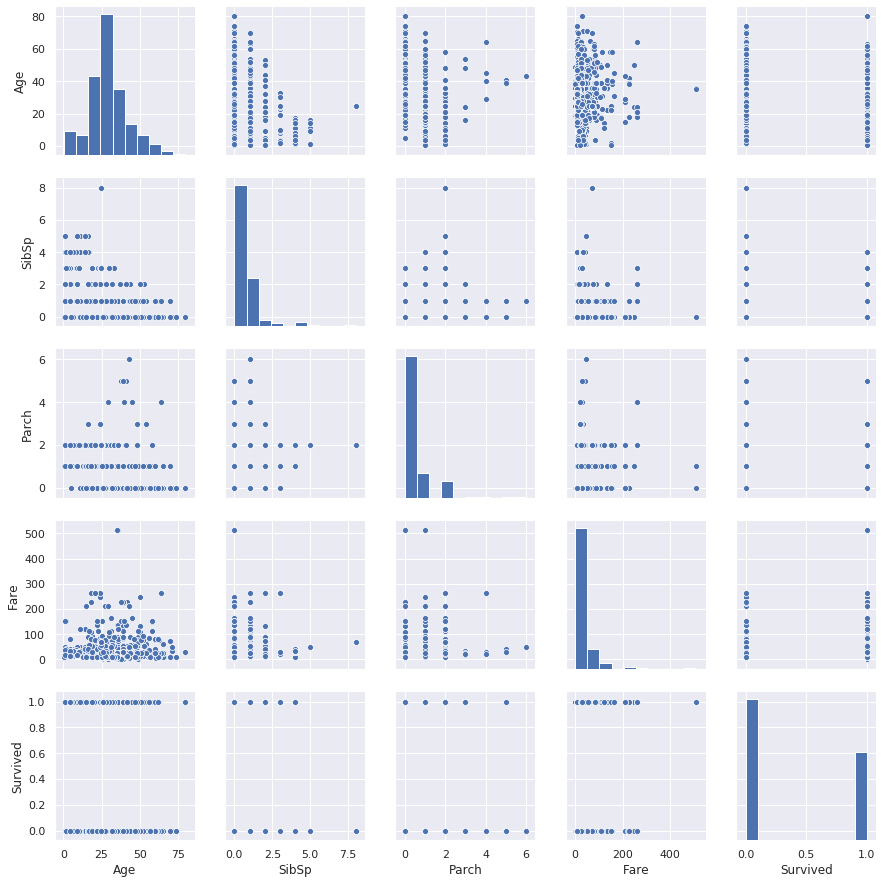

In [13]:
temp_df = pd.merge(one_hot_df[numeric_columns], y_true, left_index=True, right_index=True)

sns.pairplot(temp_df)

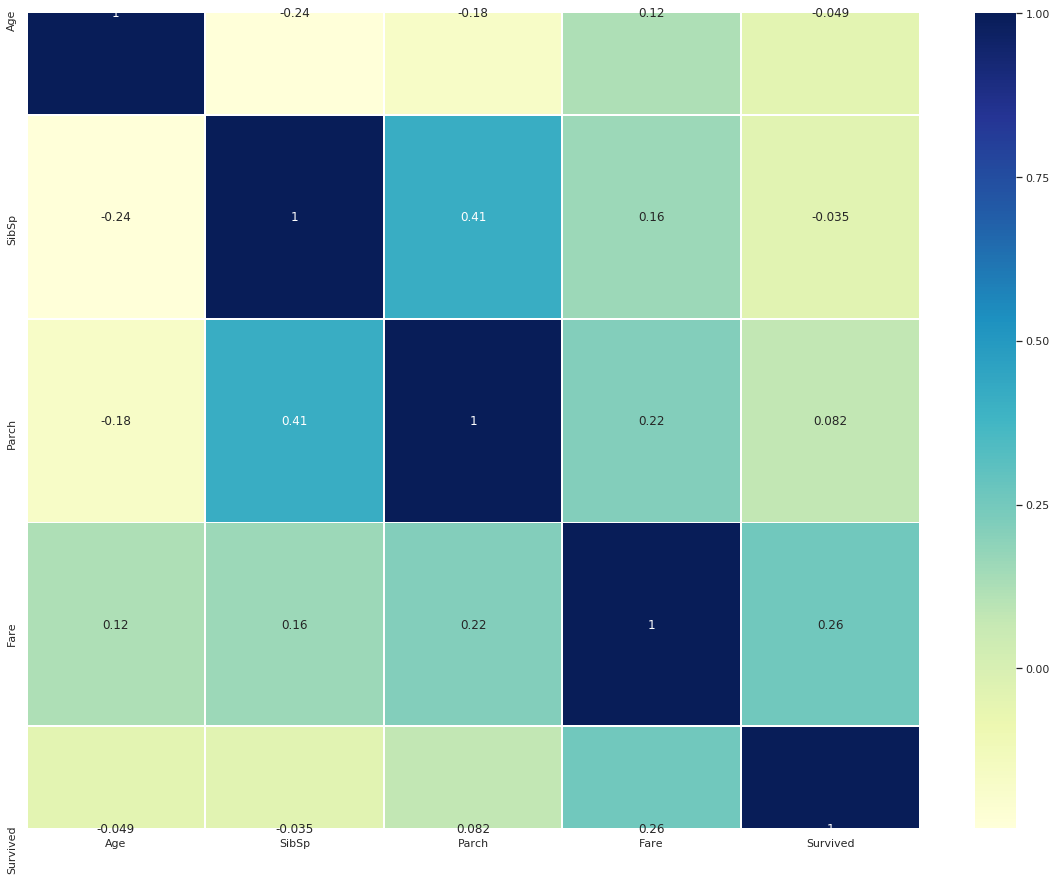

In [14]:
corr =  temp_df.corr()
sns.set()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr, annot=True,  linewidths=.8, cmap="YlGnBu")

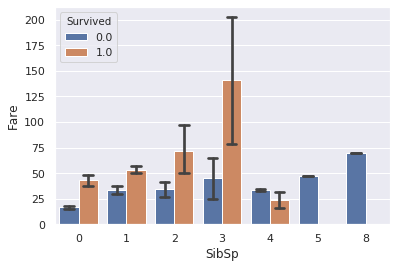

In [15]:
sns.barplot(x="SibSp", y="Fare", hue="Survived", data=temp_df, ci=68, capsize=.2)

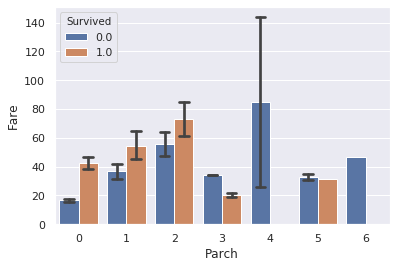

In [16]:
sns.barplot(x="Parch", y="Fare", hue="Survived", data=temp_df, ci=68, capsize=.2)

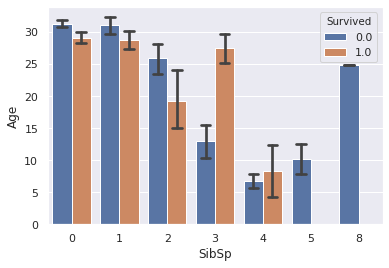

In [17]:
sns.barplot(x="SibSp", y="Age", hue="Survived", data=temp_df, ci=68, capsize=.2)

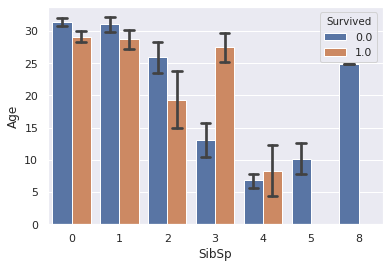

In [18]:
sns.barplot(x="SibSp", y="Age", hue="Survived", data=temp_df, ci=68, capsize=.2)

### Bining 

In [19]:
one_hot_df["Fare"].value_counts()

8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
           ..
33.5000     1
7.8000      1
26.3875     1
15.5792     1
7.1417      1
Name: Fare, Length: 281, dtype: int64

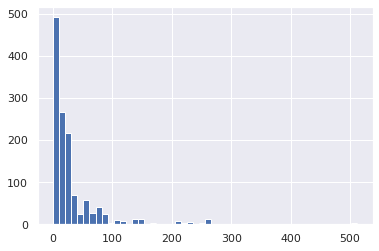

In [20]:
one_hot_df["Fare"].hist(bins=50)

In [21]:
one_hot_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SexPclass_male3,EmbarkedPclass_C1,EmbarkedPclass_C2,EmbarkedPclass_C3,EmbarkedPclass_Q1,EmbarkedPclass_Q2,EmbarkedPclass_Q3,EmbarkedPclass_S1,EmbarkedPclass_S2,EmbarkedPclass_S3
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,...,1,0,0,0,0,0,0,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,...,0,1,0,0,0,0,0,0,0,0
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,...,0,0,0,0,0,0,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,...,0,0,0,0,0,0,0,1,0,0
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,24.816367,0,0,A.5. 3236,8.0500,NaN,...,1,0,0,0,0,0,0,0,0,1
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,...,0,1,0,0,0,0,0,0,0,0
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,1,0,0,0,0,0,0,0,0,1
1307,1308,3,"Ware, Mr. Frederick",male,24.816367,0,0,359309,8.0500,NaN,...,1,0,0,0,0,0,0,0,0,1


/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


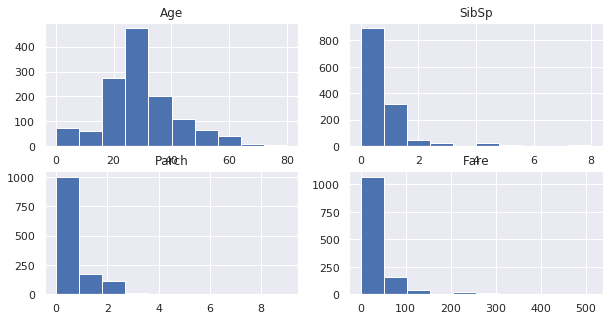

In [22]:
fig = plt.figure()
fig.set_size_inches(10,5) # 싸이즈 설정

ax = []
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, col_name in enumerate(numeric_columns):
    ax.append(fig.add_subplot(2,2,i+1)) # 두개의 plot 생성
    X_1 = one_hot_df[col_name]
    
    ax[i].hist(X_1)
    ax[i].set_title(col_name)

In [23]:
df["Parch"].value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

In [24]:
bins = [-1, 0, 2, 5, 9]
group_name = ["l1", "l2", "l3", "l4"]

bin_one_hot_df = merge_and_get(one_hot_df,
    pd.get_dummies(pd.cut(df["Parch"], bins, labels=group_name ), prefix="parch"), on=None, index=True)

bins = [-1, 0, 1, 4, 10]
group_name = ["l1", "l2", "l3", "l4"]
bin_one_hot_df = merge_and_get(bin_one_hot_df,
    pd.get_dummies(pd.cut(df["SibSp"], bins, labels=group_name ), prefix="SibSp"), on=None, index=True)

bin_one_hot_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,EmbarkedPclass_S2,EmbarkedPclass_S3,parch_l1,parch_l2,parch_l3,parch_l4,SibSp_l1,SibSp_l2,SibSp_l3,SibSp_l4
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,...,0,1,1,0,0,0,0,1,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,...,0,0,1,0,0,0,0,1,0,0
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,...,0,1,1,0,0,0,1,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,...,0,0,1,0,0,0,0,1,0,0
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,...,0,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,24.816367,0,0,A.5. 3236,8.0500,NaN,...,0,1,1,0,0,0,1,0,0,0
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,...,0,0,1,0,0,0,1,0,0,0
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,0,1,1,0,0,0,1,0,0,0
1307,1308,3,"Ware, Mr. Frederick",male,24.816367,0,0,359309,8.0500,NaN,...,0,1,1,0,0,0,1,0,0,0


### Log Transform

In [25]:
bin_one_hot_df.isnull().sum()

PassengerId             0
Pclass                  0
Name                    0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    1
Cabin                1014
Embarked                0
Sex_female              0
Sex_male                0
Pclass_1                0
Pclass_2                0
Pclass_3                0
Embarked_C              0
Embarked_Q              0
Embarked_S              0
Sex-Pclass              0
Embarked-Pclass         0
SexPclass_female1       0
SexPclass_female2       0
SexPclass_female3       0
SexPclass_male1         0
SexPclass_male2         0
SexPclass_male3         0
EmbarkedPclass_C1       0
EmbarkedPclass_C2       0
EmbarkedPclass_C3       0
EmbarkedPclass_Q1       0
EmbarkedPclass_Q2       0
EmbarkedPclass_Q3       0
EmbarkedPclass_S1       0
EmbarkedPclass_S2       0
EmbarkedPclass_S3       0
parch_l1                0
parch_l2                0
parch_l3    

In [26]:
bin_one_hot_df["Fare"] = bin_one_hot_df["Fare"].fillna(bin_one_hot_df["Fare"].mean())
# bin_one_hot_df.isnull().sum()

In [27]:
log_bin_one_hot_df = merge_and_get(bin_one_hot_df, np.log10(bin_one_hot_df["Fare"]+0.5), on=None, index=True)

log_bin_one_hot_df.rename(columns={'Fare_x':'Fare',
                          'Fare_y':'log_fare'}, 
                 inplace=True)
log_bin_one_hot_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,EmbarkedPclass_S3,parch_l1,parch_l2,parch_l3,parch_l4,SibSp_l1,SibSp_l2,SibSp_l3,SibSp_l4,log_fare
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,...,1,1,0,0,0,0,1,0,0,0.889302
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,...,0,1,0,0,0,0,1,0,0,1.856023
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,...,1,1,0,0,0,1,0,0,0,0.925570
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,...,0,1,0,0,0,0,1,0,0,1.729165
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,...,1,1,0,0,0,1,0,0,0,0.931966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,24.816367,0,0,A.5. 3236,8.0500,NaN,...,1,1,0,0,0,1,0,0,0,0.931966
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,...,0,1,0,0,0,1,0,0,0,2.039017
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,1,1,0,0,0,1,0,0,0,0.889302
1307,1308,3,"Ware, Mr. Frederick",male,24.816367,0,0,359309,8.0500,NaN,...,1,1,0,0,0,1,0,0,0,0.931966


In [28]:
object_columns

['PassengerId', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

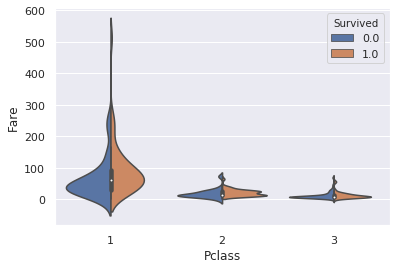

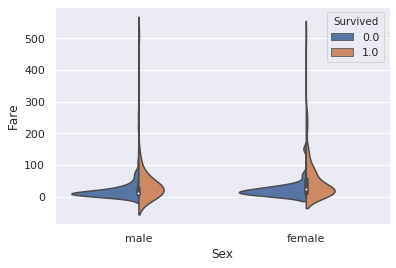

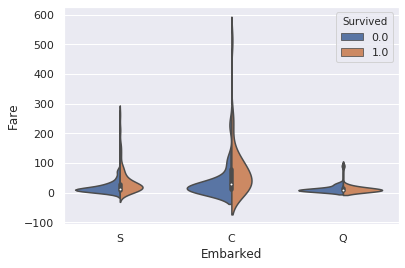

In [29]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns+object_columns], y_true, left_index=True, right_index=True)

for col_name in ["Pclass","Sex","Embarked" ]:
    sns.violinplot(x=col_name, y="Fare", hue="Survived", data=temp_df, split=True)
    plt.show()

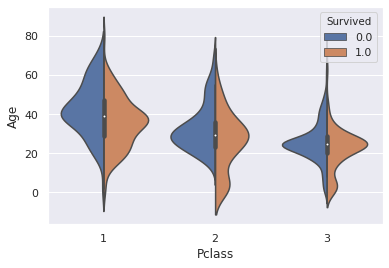

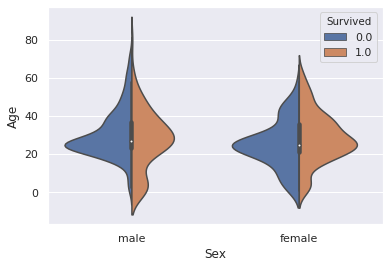

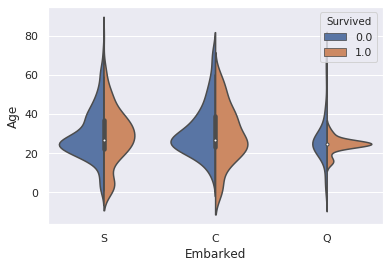

In [30]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns+object_columns], y_true, left_index=True, right_index=True)

for col_name in ["Pclass","Sex","Embarked" ]:
    sns.violinplot(x=col_name, y="Age", hue="Survived", data=temp_df, split=True)
    plt.show()

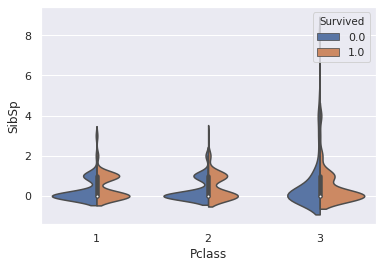

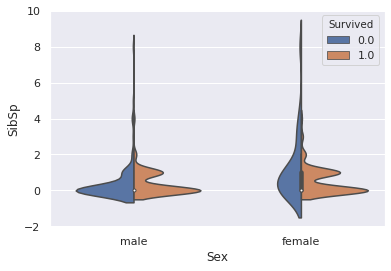

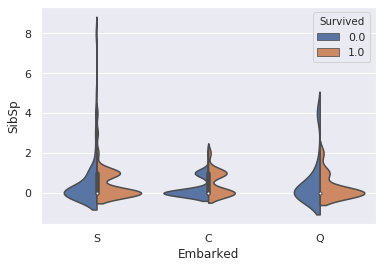

In [31]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns+object_columns], y_true, left_index=True, right_index=True)

for col_name in ["Pclass","Sex","Embarked" ]:
    sns.violinplot(x=col_name, y="SibSp", hue="Survived", data=temp_df, split=True)
    plt.show()

/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/seaborn/categorical.py:2974: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


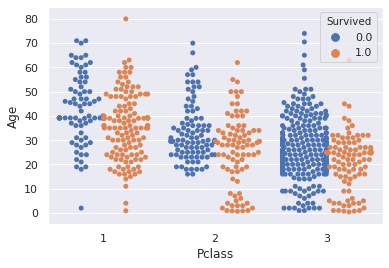

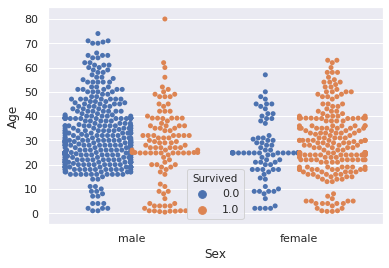

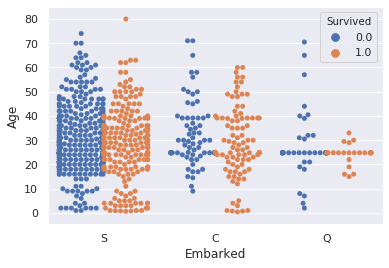

In [32]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns+object_columns], y_true, left_index=True, right_index=True)

for col_name in ["Pclass","Sex","Embarked" ]:
    sns.swarmplot(x=col_name, y="Age", hue="Survived", data=temp_df, split=True)
    plt.show()

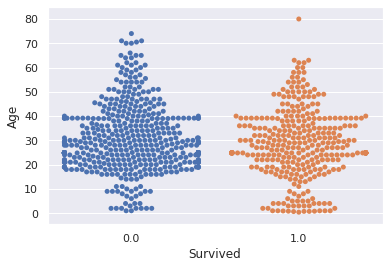

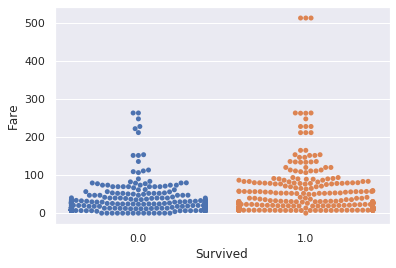

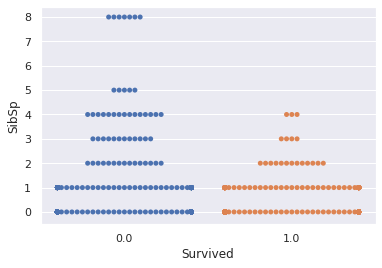

In [33]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns+object_columns], y_true, left_index=True, right_index=True)

for col_name in ["Age","Fare","SibSp" ]:
    sns.swarmplot(x="Survived", y=col_name, data=temp_df, split=True)
    plt.show()

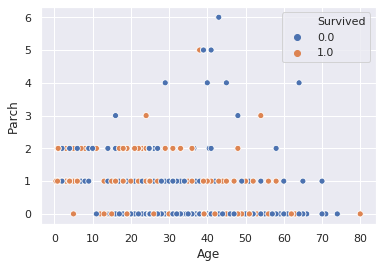

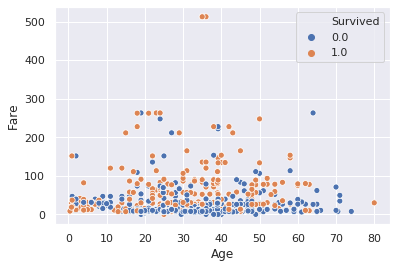

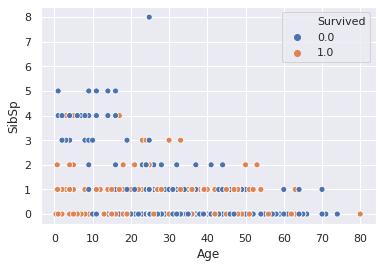

In [34]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns+object_columns], y_true, left_index=True, right_index=True)
for col_name in ["Parch","Fare","SibSp" ]:
    sns.scatterplot(x="Age", y=col_name, data=temp_df, hue="Survived")
    plt.show()

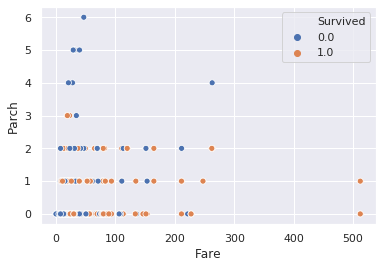

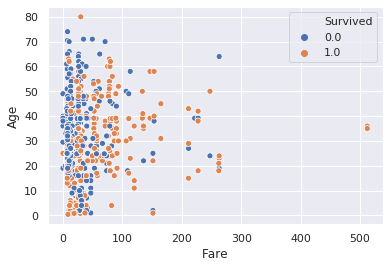

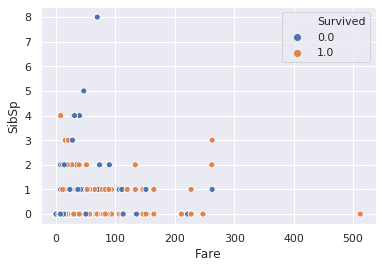

In [35]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns+object_columns], y_true, left_index=True, right_index=True)
for col_name in ["Parch","Age","SibSp" ]:
    sns.scatterplot(x="Fare", y=col_name, data=temp_df, hue="Survived")
    plt.show()

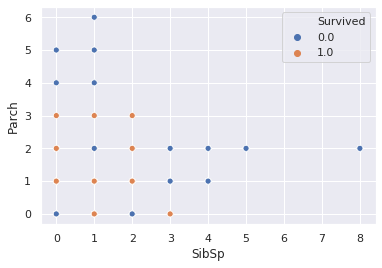

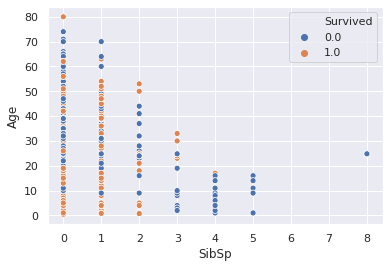

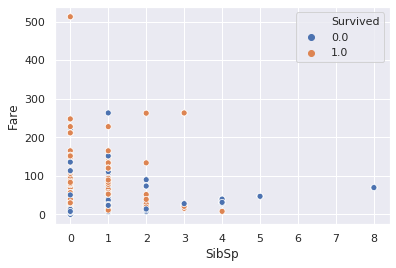

In [36]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns+object_columns], y_true, left_index=True, right_index=True)
for col_name in ["Parch","Age","Fare" ]:
    sns.scatterplot(x="SibSp", y=col_name, data=temp_df, hue="Survived")
    plt.show()

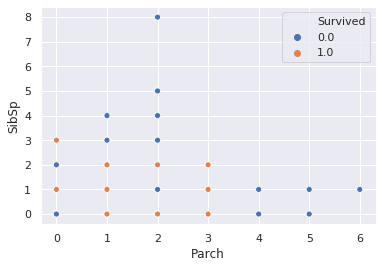

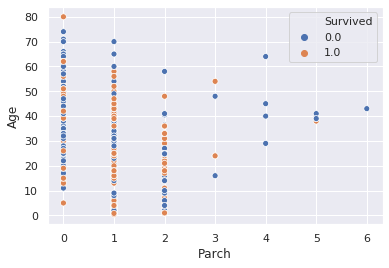

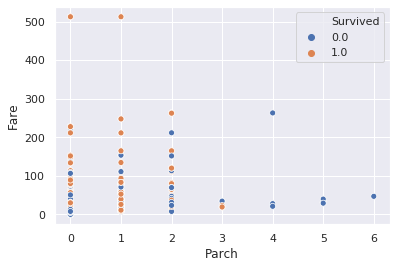

In [37]:
temp_df = pd.merge(log_bin_one_hot_df[numeric_columns+object_columns], y_true, left_index=True, right_index=True)
for col_name in ["SibSp","Age","Fare" ]:
    sns.scatterplot(x="Parch", y=col_name, data=temp_df, hue="Survived")
    plt.show()

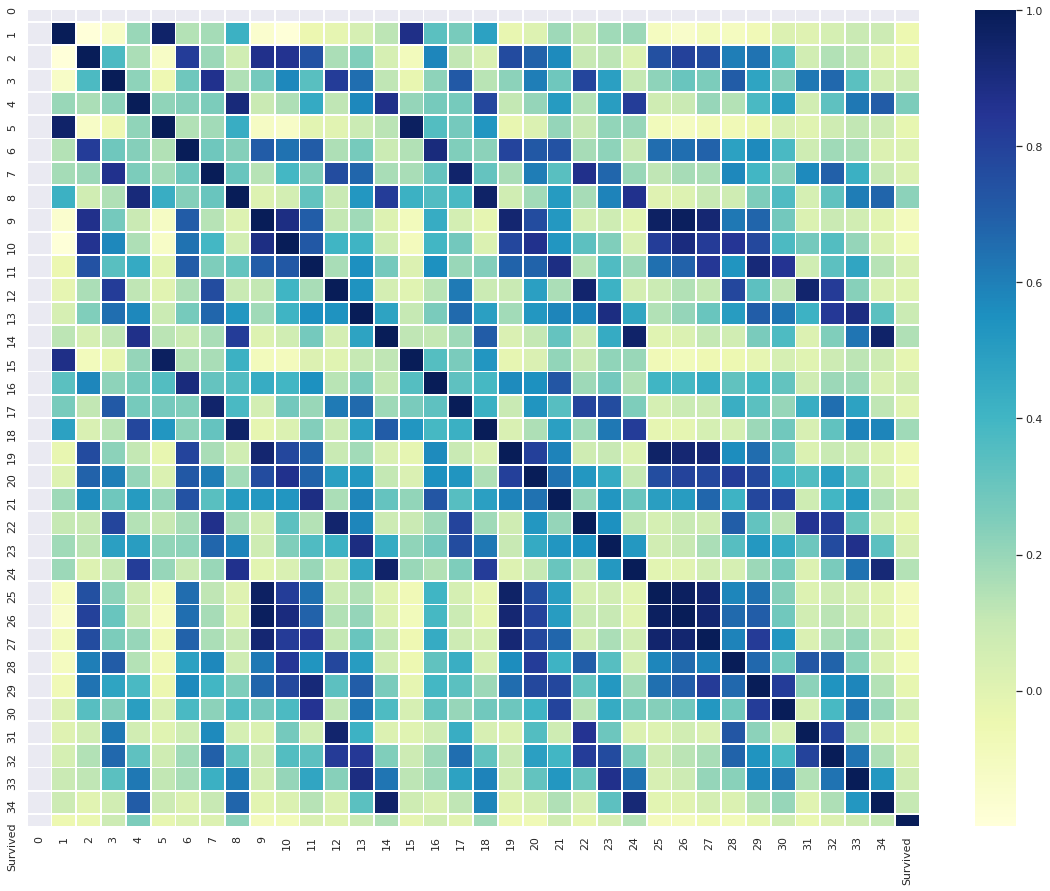

In [38]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3)
X_poly = pd.DataFrame(
    poly_features.fit_transform(log_bin_one_hot_df[numeric_columns]))

temp_df = pd.concat([X_poly, y_true], axis=1)
corr =  temp_df.corr()
sns.set()
plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr,  linewidths=.8, cmap="YlGnBu")

### String handling

In [39]:
from collections import Counter
Counter((log_bin_one_hot_df["Name"].str.lower() + " ").sum().split()).most_common(3)

[('mr.', 757), ('miss.', 260), ('mrs.', 197)]

In [40]:
log_bin_one_hot_df["is_mr"] = log_bin_one_hot_df["Name"].str.lower().str.contains(pat = 'mr.') 
log_bin_one_hot_df["is_miss"] = log_bin_one_hot_df["Name"].str.lower().str.contains(pat = 'miss.') 
log_bin_one_hot_df["is_mrs"] = log_bin_one_hot_df["Name"].str.lower().str.contains(pat = 'mrs.') 

In [41]:
log_bin_one_hot_df["Ticket"].str.rsplit(expand=True, )

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
1304,A.5.,3236,None
1305,PC,17758,None
1306,SOTON/O.Q.,3101262,None
1307,359309,None,None


In [42]:
log_bin_one_hot_df["Ticket"].str.extractall('(\d+)')

0
     match         
0    0            5
     1        21171
1    0        17599
2    0            2
     1      3101282
...             ...
1304 1         3236
1305 0        17758
1306 0      3101262
1307 0       359309
1308 0         2668

[1373 rows x 1 columns]

In [43]:
Counter((log_bin_one_hot_df["Ticket"].str.lower() + " ").sum().split()).most_common(30)

[('pc', 92),
 ('c.a.', 46),
 ('sc/paris', 16),
 ('soton/o.q.', 16),
 ('2.', 15),
 ('w./c.', 14),
 ('ston/o', 14),
 ('a/5', 12),
 ('ca.', 12),
 ('2343', 11),
 ('a/5.', 10),
 ('ca', 10),
 ('f.c.c.', 9),
 ('2144', 8),
 ('1601', 8),
 ('soton/oq', 8),
 ('c', 8),
 ('ston/o2.', 7),
 ('347082', 7),
 ('347077', 7),
 ('3101295', 7),
 ('s.o.c.', 7),
 ('14879', 7),
 ('17608', 7),
 ('s.o./p.p.', 7),
 ('382652', 6),
 ('19950', 6),
 ('347088', 6),
 ('113781', 6),
 ('a/4', 6)]

In [44]:
log_bin_one_hot_df["is_pc"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'pc') 
log_bin_one_hot_df["is_ca"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'c.a.')  | log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'ca')
log_bin_one_hot_df["is_paris"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'paris')
log_bin_one_hot_df["is_soton"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'soton')
log_bin_one_hot_df["is_ston"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 'ston')
log_bin_one_hot_df["is_so"] = log_bin_one_hot_df["Ticket"].str.lower().str.contains(pat = 's.o')


In [45]:
log_bin_one_hot_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,log_fare,is_mr,is_miss,is_mrs,is_pc,is_ca,is_paris,is_soton,is_ston,is_so
0,1,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,...,0.889302,True,False,False,False,False,False,False,False,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,...,1.856023,True,False,True,True,False,False,False,False,False
2,3,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,...,0.925570,False,True,False,False,False,False,False,True,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,...,1.729165,True,False,True,False,False,False,False,False,False
4,5,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,...,0.931966,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,"Spector, Mr. Woolf",male,24.816367,0,0,A.5. 3236,8.0500,NaN,...,0.931966,True,False,False,False,False,False,False,False,False
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,...,2.039017,False,False,False,True,False,False,False,False,False
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,0.889302,True,False,False,False,False,False,True,False,False
1307,1308,3,"Ware, Mr. Frederick",male,24.816367,0,0,359309,8.0500,NaN,...,0.931966,True,False,False,False,False,False,False,False,False


In [46]:
log_bin_one_hot_df.isnull().sum()

PassengerId             0
Pclass                  0
Name                    0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                1014
Embarked                0
Sex_female              0
Sex_male                0
Pclass_1                0
Pclass_2                0
Pclass_3                0
Embarked_C              0
Embarked_Q              0
Embarked_S              0
Sex-Pclass              0
Embarked-Pclass         0
SexPclass_female1       0
SexPclass_female2       0
SexPclass_female3       0
SexPclass_male1         0
SexPclass_male2         0
SexPclass_male3         0
EmbarkedPclass_C1       0
EmbarkedPclass_C2       0
EmbarkedPclass_C3       0
EmbarkedPclass_Q1       0
EmbarkedPclass_Q2       0
EmbarkedPclass_Q3       0
EmbarkedPclass_S1       0
EmbarkedPclass_S2       0
EmbarkedPclass_S3       0
parch_l1                0
parch_l2                0
parch_l3    

In [47]:
test = log_bin_one_hot_df["Cabin"].fillna("99999")
Counter((test.str.lower() + " ").sum().split()).most_common(30)

[('99999', 1014),
 ('f', 8),
 ('c23', 6),
 ('c25', 6),
 ('c27', 6),
 ('g6', 5),
 ('b57', 5),
 ('b59', 5),
 ('b63', 5),
 ('b66', 5),
 ('f33', 4),
 ('f2', 4),
 ('f4', 4),
 ('c78', 4),
 ('d', 4),
 ('c22', 4),
 ('c26', 4),
 ('b96', 4),
 ('b98', 4),
 ('e46', 3),
 ('b58', 3),
 ('b60', 3),
 ('e101', 3),
 ('e34', 3),
 ('a34', 3),
 ('c101', 3),
 ('b51', 3),
 ('b53', 3),
 ('b55', 3),
 ('c85', 2)]

In [48]:
log_bin_one_hot_df["is_cabin_none"] = test.str.contains(pat = '9999')
log_bin_one_hot_df["is_cabin_a"] = test.str.contains(pat = 'a')
log_bin_one_hot_df["is_cabin_b"] = test.str.contains(pat = 'b')
log_bin_one_hot_df["is_cabin_c"] = test.str.contains(pat = 'c')
log_bin_one_hot_df["is_cabin_d"] = test.str.contains(pat = 'd')
log_bin_one_hot_df["is_cabin_e"] = test.str.contains(pat = 'e')
log_bin_one_hot_df["is_cabin_f"] = test.str.contains(pat = 'f')
log_bin_one_hot_df["is_cabin_g"] = test.str.contains(pat = 'g')

In [49]:
log_bin_one_hot_df.head(2).T

,0,1
PassengerId,1,2
Pclass,3,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th..."
Sex,male,female
Age,22,38
...,...,...
is_cabin_c,False,False
is_cabin_d,False,False
is_cabin_e,False,False
is_cabin_f,False,False


In [50]:
log_bin_one_hot_df.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
              ..
is_cabin_c     0
is_cabin_d     0
is_cabin_e     0
is_cabin_f     0
is_cabin_g     0
Length: 62, dtype: int64

In [51]:
def count_cabin(x):
    if type(x) is int:
        return 0
    else:
        return len(x)
log_bin_one_hot_df["number_of_Cabin"] = log_bin_one_hot_df["Cabin"].str.split(" ").fillna(0).map(count_cabin)
log_bin_one_hot_df["log_number_of_Cabin"] = np.log(log_bin_one_hot_df["number_of_Cabin"] + 0.01)

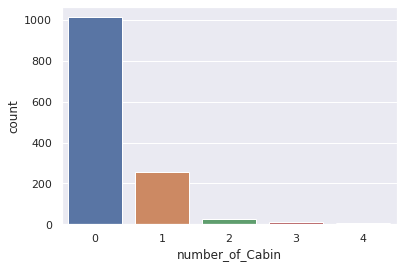

In [52]:
sns.countplot(log_bin_one_hot_df["number_of_Cabin"])

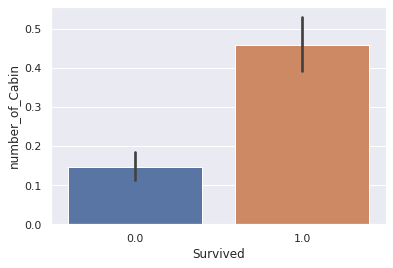

                     number_of_Cabin  log_number_of_Cabin  Survived
number_of_Cabin             1.000000             0.924291  0.277053
log_number_of_Cabin         0.924291             1.000000  0.314632
Survived                    0.277053             0.314632  1.000000


In [53]:
temp_df = pd.merge(log_bin_one_hot_df[["number_of_Cabin", "log_number_of_Cabin"]], y_true, left_index=True, right_index=True)
sns.barplot(x="Survived", y="number_of_Cabin", data=temp_df)
plt.show()
print(temp_df.corr())

### Feature Elimination

In [54]:
features = log_bin_one_hot_df.columns.tolist()
features

['PassengerId',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Sex_female',
 'Sex_male',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Sex-Pclass',
 'Embarked-Pclass',
 'SexPclass_female1',
 'SexPclass_female2',
 'SexPclass_female3',
 'SexPclass_male1',
 'SexPclass_male2',
 'SexPclass_male3',
 'EmbarkedPclass_C1',
 'EmbarkedPclass_C2',
 'EmbarkedPclass_C3',
 'EmbarkedPclass_Q1',
 'EmbarkedPclass_Q2',
 'EmbarkedPclass_Q3',
 'EmbarkedPclass_S1',
 'EmbarkedPclass_S2',
 'EmbarkedPclass_S3',
 'parch_l1',
 'parch_l2',
 'parch_l3',
 'parch_l4',
 'SibSp_l1',
 'SibSp_l2',
 'SibSp_l3',
 'SibSp_l4',
 'log_fare',
 'is_mr',
 'is_miss',
 'is_mrs',
 'is_pc',
 'is_ca',
 'is_paris',
 'is_soton',
 'is_ston',
 'is_so',
 'is_cabin_none',
 'is_cabin_a',
 'is_cabin_b',
 'is_cabin_c',
 'is_cabin_d',
 'is_cabin_e',
 'is_cabin_f',
 'is_cabin_g',
 'number_of_Cabin',
 'log_number_of_Cabin']

In [55]:
all_df = log_bin_one_hot_df.copy(deep=True)

elimination_features= ['PassengerId','Name','Cabin','Ticket']
for col_name in elimination_features:
    all_df.drop(col_name , axis=1, inplace=True)

In [56]:
all_df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_female,Sex_male,Pclass_1,...,is_cabin_none,is_cabin_a,is_cabin_b,is_cabin_c,is_cabin_d,is_cabin_e,is_cabin_f,is_cabin_g,number_of_Cabin,log_number_of_Cabin
0,3,male,22.000000,1,0,7.2500,S,0,1,0,...,True,False,False,False,False,False,False,False,0,-4.60517
1,1,female,38.000000,1,0,71.2833,C,1,0,1,...,False,False,False,False,False,False,False,False,1,0.00995
2,3,female,26.000000,0,0,7.9250,S,1,0,0,...,True,False,False,False,False,False,False,False,0,-4.60517
3,1,female,35.000000,1,0,53.1000,S,1,0,1,...,False,False,False,False,False,False,False,False,1,0.00995
4,3,male,35.000000,0,0,8.0500,S,0,1,0,...,True,False,False,False,False,False,False,False,0,-4.60517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,male,24.816367,0,0,8.0500,S,0,1,0,...,True,False,False,False,False,False,False,False,0,-4.60517
1305,1,female,39.000000,0,0,108.9000,C,1,0,1,...,False,False,False,False,False,False,False,False,1,0.00995
1306,3,male,38.500000,0,0,7.2500,S,0,1,0,...,True,False,False,False,False,False,False,False,0,-4.60517
1307,3,male,24.816367,0,0,8.0500,S,0,1,0,...,True,False,False,False,False,False,False,False,0,-4.60517


In [57]:
del all_df["Sex"]
del all_df["Pclass"]
del all_df["Embarked"]

In [58]:
del all_df["Sex-Pclass"]
del all_df["Embarked-Pclass"]

In [98]:
X_dev = all_df[:number_of_train_dataset].values
X_test = all_df[number_of_train_dataset:].values
y_dev = y_true.copy()

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev)

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
clf = DecisionTreeClassifier( max_depth=20, random_state=0)
clf.fit(X_train, y_train)  

y_pred = clf.predict(X_train)
y_true = y_train
print(accuracy_score(y_true, y_pred))


y_pred = clf.predict(X_val)
y_true = y_val
print(accuracy_score(y_true, y_pred))

# clf.fit(X_train_selected, y_train)  



0.9925149700598802
0.7443946188340808


In [101]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [102]:
from sklearn.model_selection import RandomizedSearchCV

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_random = RandomizedSearchCV(
    estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_dev, y_dev)

report(rf_random.cv_results_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.8s


Model with rank: 1
Mean validation score: 0.802 (std: 0.021)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.800 (std: 0.016)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10}

Model with rank: 3
Mean validation score: 0.799 (std: 0.007)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80}

Model with rank: 3
Mean validation score: 0.799 (std: 0.007)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40}

Model with rank: 3
Mean validation score: 0.799 (std: 0.007)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 70}

Model with rank: 3
Mean validation score: 0.799 (std: 0.007)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110}

Model with rank: 3
M

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    7.4s finished


In [103]:
clf = rf_random.best_estimator_
y_pred = clf.predict(X_val)
y_true = y_val
print(accuracy_score(y_true, y_pred))

0.8565022421524664


In [104]:
from sklearn.model_selection import GridSearchCV

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 40, num = 40)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in range(2,11)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]

grid_parm = {
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

dt_grid = GridSearchCV(
    estimator = clf, param_grid = grid_parm, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
dt_grid.fit(X_dev, y_dev)

report(dt_grid.cv_results_)

Fitting 3 folds for each of 738 candidates, totalling 2214 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1690 tasks      | elapsed:   21.6s


Model with rank: 1
Mean validation score: 0.805 (std: 0.025)
Parameters: {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.805 (std: 0.025)
Parameters: {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.805 (std: 0.025)
Parameters: {'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4}

Model with rank: 1
Mean validation score: 0.805 (std: 0.025)
Parameters: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.805 (std: 0.025)
Parameters: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3}

Model with rank: 1
Mean validation score: 0.805 (std: 0.025)
Parameters: {'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4}

Model with rank: 1
Mea

[Parallel(n_jobs=-1)]: Done 2214 out of 2214 | elapsed:   27.1s finished


In [105]:
clf = dt_grid.best_estimator_
y_pred = clf.predict(X_val)
y_true = y_val
print(accuracy_score(y_true, y_pred))

0.8565022421524664


In [121]:
np.isnan(X_train)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [123]:
from hpsklearn import HyperoptEstimator, decision_tree
from sklearn import svm

estim = HyperoptEstimator(classifier=decision_tree('myDT'))
estim.fit(X_train, y_train)

print(estim.score(X_val, y_val))

  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]

/home/sc82choi/miniconda3/envs/dsme/lib/python3.6/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]



  0%|          | 0/1 [00:00<?, ?it/s, best loss: ?]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').